In [2]:
import numpy as np

In [34]:
import random

In [205]:
import matplotlib.pyplot as plt

In [275]:
import tensorflow as tf

In [3]:
!ls ../../waveforms/july2021/time_pars_subnetwork_test/training_data/

amplitude.npy coords.npy    phase.npy     times.npy


In [4]:
coords = np.load('../../waveforms/july2021/time_pars_subnetwork_test/training_data/coords.npy')
amplitude = np.load('../../waveforms/july2021/time_pars_subnetwork_test/training_data/amplitude.npy')
times = np.load('../../waveforms/july2021/time_pars_subnetwork_test/training_data/times.npy')

In [5]:
coords.shape

(9, 10)

In [6]:
amplitude.shape

(10, 1119)

In [7]:
times.shape

(1119,)

In [8]:
coords[0]

array([6.72379423, 3.0681369 , 3.09777838, 4.42349109, 5.40995702,
       4.08211941, 4.84773548, 5.17268127, 7.75904102, 4.9435199 ])

In [9]:
coords[1]

array([0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99])

In [10]:
coords[2]

array([1.3898877 , 1.03401101, 0.49955079, 1.09004947, 1.46590005,
       0.82755268, 1.21532094, 0.71517227, 0.39002186, 0.8484143 ])

In [11]:
coords

array([[6.72379423, 3.0681369 , 3.09777838, 4.42349109, 5.40995702,
        4.08211941, 4.84773548, 5.17268127, 7.75904102, 4.9435199 ],
       [0.99      , 0.99      , 0.99      , 0.99      , 0.99      ,
        0.99      , 0.99      , 0.99      , 0.99      , 0.99      ],
       [1.3898877 , 1.03401101, 0.49955079, 1.09004947, 1.46590005,
        0.82755268, 1.21532094, 0.71517227, 0.39002186, 0.8484143 ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.       

In [16]:
Xq = coords.T

In [67]:
Xt = times.copy()[:,np.newaxis]

In [68]:
y = amplitude.copy()

In [69]:
Xq.shape

(10, 9)

In [70]:
Xt.shape

(1119, 1)

In [71]:
y.shape

(10, 1119)

In [278]:
Xq.shape[0] * Xt.shape[0]

11190

In [72]:
random.sample(range(Xq.shape[0]), 2)

[7, 3]

In [73]:
np.random.randint(low=0, high=Xq.shape, size=2)

array([4, 1])

In [74]:
# https://medium.com/analytics-vidhya/write-your-own-custom-data-generator-for-tensorflow-keras-1252b64e41c3

In [131]:
y[np.random.randint(low=0, high=Xq.shape, size=2)]

array([[0.00863031, 0.00861635, 0.00860234, ..., 0.00069154, 0.0006603 ,
        0.0006564 ],
       [0.01104128, 0.01104891, 0.01105645, ..., 0.00242328, 0.00234043,
        0.00226024]])

In [126]:
y.shape

(10, 1119)

In [272]:
def simulate_epoch(Xq, Xt, y):
    
    # get a batch of Xqs
    q_batch_size = 5
    Xq_i = random.sample(range(Xq.shape[0]), q_batch_size)
#     Xq_i = [1]
    
    # get a batch of times
    t_batch_size = 100
    Xt_i = random.sample(range(Xt.shape[0]), t_batch_size)
#     Xt_i = range(len(Xt))

    # `ones` is used to broadcast the physical parameters to the same shape as the times so that we can concat them
    ones = np.ones(shape=(Xt[Xt_i].shape[0], Xq[Xq_i].shape[1]))    
    
    X_train = []
    for q in Xq[Xq_i]:
        sub_matrix = np.array([q]) * ones
        X_train.append(np.concatenate((Xt[Xt_i], sub_matrix), axis=1))
    X_train = np.asarray(X_train)
    X_train = X_train.reshape(X_train.shape[0]*X_train.shape[1], X_train.shape[2])
    y_train = y[Xq_i][:,Xt_i].reshape(-1,1)
    
    return X_train, y_train, Xq_i

In [273]:
X_train, y_train, qi = simulate_epoch(Xq, Xt, y)

In [269]:
X_train.shape

(500, 10)

In [270]:
y_train.shape

(500, 1)

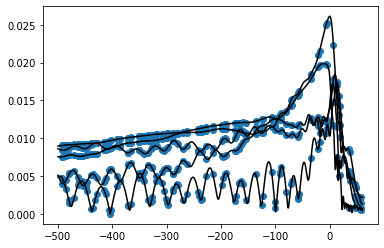

In [274]:
plt.figure()
plt.scatter(X_train[:,0], y_train[:,0])

for ii in qi:
    plt.plot(times, amplitude[ii], c='k')
# plt.xlim(0, 100)

# try using sequence

In [280]:
import math

In [295]:
class DataGen(tf.keras.utils.Sequence):
    def __init__(self, X, t, y, X_batch_size, t_batch_size, shuffle=True):
        """
        X: array of physical parameters
        t: array of times
        y: array of targets
        X_batch_size: number of samples to take from X
        t_batch_size: number of samples to take from t
            total mini-batch size is `X_batch_size`*`t_batch_size`
            
        in this function we just take batches of the physical parameters
        and randomly add `t_batch_size` samples to it.
        
        https://medium.com/analytics-vidhya/write-your-own-custom-data-generator-for-tensorflow-keras-1252b64e41c3
        https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
        """
        self.X = X
        self.t = t
        self.y = y
        self.lenX = len(self.X)
        self.lenT = len(self.t)
        self.batch_size = X_batch_size
        self.t_batch_size = t_batch_size
        self.shuffle = shuffle
        
        # init self.indexes
        self.on_epoch_end()
        
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(self.lenX)
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __getitem__(self, idx):
        
        x_start_idx = idx * self.batch_size
        x_end_idx = (idx + 1) * self.batch_size
        indicies = self.indexes[x_start_idx:x_end_idx]
        
        # an random batch of data
        x_batch = self.X[indicies]
        
        # get random indicies for time data
        t_batch_idx = random.sample(range(self.lenT), self.t_batch_size)
        
        t_batch = self.t[t_batch_idx]
        
        # `ones` is used to broadcast the physical parameters to the same shape as the times so that we can concat them
        ones = np.ones(shape=(t_batch.shape[0], x_batch.shape[1]))    

        X_train = []
        for x in x_batch:
            sub_matrix = np.array([x]) * ones
            X_train.append(np.concatenate((t_batch, sub_matrix), axis=1))
        X_train = np.asarray(X_train)
        X_train = X_train.reshape(X_train.shape[0]*X_train.shape[1], X_train.shape[2])
        y_train = y[indicies][:,t_batch_idx].reshape(-1,1)
        
        return X_train, y_train
    
    def __len__(self):
        return math.ceil(self.lenX / self.batch_size)

In [296]:
Xq.shape


(10, 9)

In [297]:
Xt.shape

(1119, 1)

In [384]:
sequence = DataGen(X=Xq, t=Xt, y=y, X_batch_size=10, t_batch_size=50, shuffle=True)

In [385]:
sequence.__len__()

1

In [398]:
for num, (data, labels) in enumerate(sequence):
    print(data.shape, labels.shape)
    if num > 5: break

(500, 10) (500, 1)


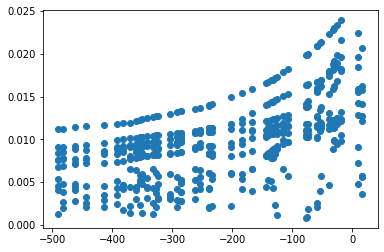

In [399]:
plt.figure()
plt.scatter(data[:,0], labels[:,0])

In [442]:
sequence[0][0][0]

array([-161.54087795,    3.0681369 ,    0.99      ,    1.03401101,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ])

In [403]:
sequence[0][1].shape

(500, 1)